# Introduction to tensorflow

This portion of the tutorial, we'll discuss basics of tensorflow in the context of some illustrative numerical examples.

The first step is to import tensorflow and enable eager execution:

In [3]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

tf.executing_eagerly()

print('Loaded TensorFlow version ' + tf.__version__)

Loaded TensorFlow version 1.13.1


After version 1.7, TensorFlow supports a new execution mode that is easier for use with the interactive python interpreter. Google describes its eager execution mode as "an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later."

TensorFlow used to only support creating a graph first and only evaluating operations in the context of "sessions."

For example (this code constructs a computational graph, but does not initialize variables until Session is started):

```
import tensorflow as tf
import numpy as np

dim1 = 1
dim2 = 1
sigma = 0.1
precision = tf.float32
rho = tf.nn.relu
layers = 3

# placeholders are not compatibe with TF's eager execution mode
x = tf.placeholder(precision, shape = [dim1, None], name = 'input')

with tf.variable_scope('Model'):

    # input layer
    in_W = tf.get_variable(name = 'in_W', shape = [dim2, dim1],
            initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), 
            dtype = precision)

    in_b = tf.get_variable(name = 'in_b', shape = [dim2, 1],
            initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), 
            dtype = precision)
    
    x = rho(tf.matmul(in_W, x) + in_b)
    
    # build
    for layer in range(layers):

        W = tf.get_variable(name = 'l' + str(layer) + '_W', shape = [dim1, dim2],
                initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), 
                dtype = precision)

        b = tf.get_variable(name = 'l' + str(layer) + '_b', shape = [dim2, 1],
                initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), 
                dtype = precision)
    
        x = rho(tf.matmul(W, x) + b)
        
    # output layer description
    out_v = tf.get_variable(name = 'out_v', shape = [dim1, dim2],
         initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), 
         dtype = precision)
    
    x = tf.matmul(out_v, x, name = 'output')

with tf.Session() as sess:
    
    # variables such as weights and biases are not actually initialized until here
    sess.run(tf.global_variables_initializer())
    
```

## Basic operations

TF supports basic operations such as addition, squaring, matrix-vector products, etc.

In [3]:
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))
print(tf.encode_base64("hello world"))

# Operator overloading is also supported
print(tf.square(2) + tf.square(3))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(b'aGVsbG8gd29ybGQ', shape=(), dtype=string)
tf.Tensor(13, shape=(), dtype=int32)


You can determine the shape and data type of a tensor:

In [4]:
x = tf.matmul([[1]], [[2, 3]])
print(x.shape)
print(x.dtype)

(1, 2)
<dtype: 'int32'>


TensorFlow is compatible with python's numpy:

In [5]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.multiply(ndarray, 42)
print(tensor)


print("And NumPy operations convert Tensors to numpy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())


TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
And NumPy operations convert Tensors to numpy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]


Let's try making a tensor with some data. First, we'll create a numpy array. Then we'll convert the numpy array into a TF tensor.

In [6]:
x_data = np.array([[[ 1.,  2.,  3.], [ 4.,  5.,  6.]],
                   [[ 7.,  8.,  9.], [10., 11., 12.]],
                   [[13., 14., 15.], [16., 17., 18.]]])

print(x_data)

print('\n x has shape: \n')

print(np.shape(x_data))

# now let's make a TF tensor from the data
x = tf.convert_to_tensor(x_data, dtype = tf.float32)

print('\n x is now a \n')

print(x)

[[[ 1.  2.  3.]
  [ 4.  5.  6.]]

 [[ 7.  8.  9.]
  [10. 11. 12.]]

 [[13. 14. 15.]
  [16. 17. 18.]]]

 x has shape: 

(3, 2, 3)

 x is now a 

tf.Tensor(
[[[ 1.  2.  3.]
  [ 4.  5.  6.]]

 [[ 7.  8.  9.]
  [10. 11. 12.]]

 [[13. 14. 15.]
  [16. 17. 18.]]], shape=(3, 2, 3), dtype=float32)


## Automatic differentiation

TensorFlow provides the tf.GradientTape API for automatic differentiation - computing the gradient of a computation with respect to its input variables. Tensorflow "records" all operations executed inside the context of a tf.GradientTape onto a "tape". Tensorflow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using reverse mode differentiation.

For example:

In [9]:
x = tf.ones((2, 2))

print(x)

with tf.GradientTape() as t:
    t.watch(x)
    # take sum of elements of x
    y = tf.reduce_sum(x)
    print(y)
    # multiply to get y^2
    z = tf.multiply(y, y)
    print(z)

# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z, x)
print(dz_dx)
for i in [0, 1]:
    for j in [0, 1]:
        assert dz_dx[i][j].numpy() == 8.0


tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


You can also request gradients of the output with respect to intermediate values computed during a "recorded" tf.GradientTape context.

In [12]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
    t.watch(x)
    # take sum of elements of x
    y = tf.reduce_sum(x)
    print(y)
    # multiply to get y^2
    z = tf.multiply(y, y)
    print(z)

# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
assert dz_dy.numpy() == 8.0


tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(16.0, shape=(), dtype=float32)


Because tapes record operations as they are executed, Python control flow (using ifs and whiles for example) is naturally handled:

In [9]:
def f(x, y):
    output = 1.0
    for i in range(y):
        if i > 1 and i < 5:
            output = tf.multiply(output, x)
    return output

def grad(x, y):
    with tf.GradientTape() as t:
        t.watch(x)
        out = f(x, y)
    return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

assert grad(x, 6).numpy() == 12.0
assert grad(x, 5).numpy() == 12.0
assert grad(x, 4).numpy() == 4.0


### Higher order gradients

Operations inside of the GradientTape context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradients as well. For example:

In [19]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        t.watch(x)
        # set y = x^3
        y = x * x * x
    # Compute the gradient inside the 't' context manager
    # which means the gradient computation is differentiable as well
    # dy/dx = 3x^2
    dy_dx = t2.gradient(y, x)
    print(dy_dx)
    
# d^2 y/dx^2 = 6x
#d2y_dx2 = t.gradient(dy_dx, x)
#print(d2y_dx2)
x = tf.Variable(10)
d2y_dx2 = t.gradient(dy_dx, x)
print(d2y_dx2)

# at x = 1, dy/dx = 3*1 = 3
assert dy_dx.numpy() == 3.0
# at x = 1, d^2 y/dx^2 = 3*2*1 = 6
assert d2y_dx2.numpy() == 6.0

tf.Tensor(3.0, shape=(), dtype=float32)
None


AttributeError: 'NoneType' object has no attribute 'numpy'

## Slicing

Slicing is a common operation performed on tensors. Let's try looking at a few slices of x

In [20]:
x_data = np.array([[[ 1.,  2.,  3.], [ 4.,  5.,  6.]],
                   [[ 7.,  8.,  9.], [10., 11., 12.]],
                   [[13., 14., 15.], [16., 17., 18.]]])

print(x_data)

print('\n x has shape: \n')

print(np.shape(x_data))

# now let's make a TF tensor from the data
x = tf.convert_to_tensor(x_data, dtype = tf.float32)

print('\n x is now a \n')

print(x)

print('Slicing is performed from a start index to a finishing index.')
print('If I slice from (0,0,0) to (3,2,3), I obtain the entire tensor: \n')
print(tf.slice(x,[0,0,0],[3,2,3])) # the whole tensor

print('\n If I slice from (1,0,0) to (2,2,3), I obtain: \n')
print(tf.slice(x,[1,0,0],[2,2,3]))

print('\n If I slice from (2,0,0) to (3,2,3), I obtain: \n')
print(tf.slice(x,[2,0,0],[1,2,3]))

print('\n If I slice from (0,1,0) to (3,1,3), I obtain: \n')
print(tf.slice(x,[0,1,0],[3,1,3]))
print(x)


[[[ 1.  2.  3.]
  [ 4.  5.  6.]]

 [[ 7.  8.  9.]
  [10. 11. 12.]]

 [[13. 14. 15.]
  [16. 17. 18.]]]

 x has shape: 

(3, 2, 3)

 x is now a 

tf.Tensor(
[[[ 1.  2.  3.]
  [ 4.  5.  6.]]

 [[ 7.  8.  9.]
  [10. 11. 12.]]

 [[13. 14. 15.]
  [16. 17. 18.]]], shape=(3, 2, 3), dtype=float32)
Slicing is performed from a start index to a finishing index.
If I slice from (0,0,0) to (3,2,3), I obtain the entire tensor: 

tf.Tensor(
[[[ 1.  2.  3.]
  [ 4.  5.  6.]]

 [[ 7.  8.  9.]
  [10. 11. 12.]]

 [[13. 14. 15.]
  [16. 17. 18.]]], shape=(3, 2, 3), dtype=float32)

 If I slice from (1,0,0) to (2,2,3), I obtain: 

tf.Tensor(
[[[ 7.  8.  9.]
  [10. 11. 12.]]

 [[13. 14. 15.]
  [16. 17. 18.]]], shape=(2, 2, 3), dtype=float32)

 If I slice from (2,0,0) to (3,2,3), I obtain: 

tf.Tensor(
[[[13. 14. 15.]
  [16. 17. 18.]]], shape=(1, 2, 3), dtype=float32)

 If I slice from (0,1,0) to (3,1,3), I obtain: 

tf.Tensor(
[[[ 4.  5.  6.]]

 [[10. 11. 12.]]

 [[16. 17. 18.]]], shape=(3, 1, 3), dtype=float32


Let's now put the few concepts we have so far ---Tensor, GradientTape, Variable --- to build and train a simple model. This typically involves a few steps:

- Define the model.
- Define a loss function.
- Obtain training data.
- Run through the training data and use an "optimizer" to adjust the variables to fit the data.

In this tutorial, we'll walk through a trivial example of a simple linear model: f(x) = x * W + b, which has two variables - W and b. Furthermore, we'll synthesize data such that a well trained model would have W = 3.0 and b = 2.0.

### Define the model

Let's define a simple class to encapsulate the variables and the computation.

In [7]:
class Model(object):
    def __init__(self):
        # Initialize variable to (5.0, 0.0)
        # In practice, these should be initialized to random values.
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0


Instructions for updating:
Colocations handled automatically by placer.


### Define a loss function

A loss function measures how well the output of a model for a given input matches the desired output. Let's use the standard L2 loss.

In [8]:
def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

### Obtain training data

Let's synthesize the training data with some noise.

In [4]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random_normal(shape=[NUM_EXAMPLES])
noise   = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

Before we train the model let's visualize where the model stands right now. We'll plot the model's predictions in red and the training data in blue.

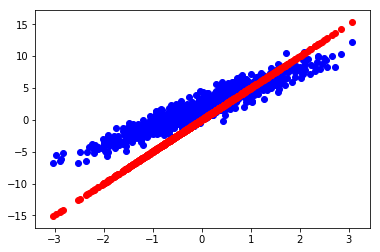

Current loss: 
8.598458


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: ')
print(loss(model(inputs), outputs).numpy())


### Define a training loop

We now have our network and our training data. Let's train it, i.e., use the training data to update the model's variables (W and b) so that the loss goes down using gradient descent. There are many variants of the gradient descent scheme that are captured in tf.train.Optimizer implementations. We'd highly recommend using those implementations, but in the spirit of building from first principles, in this particular example we will implement the basic math ourselves.

In [12]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
    dW, db = t.gradient(current_loss, [model.W, model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)


Finally, let's repeatedly run through the training data and see how W and b evolve.

Epoch  0: W=5.00 b=0.00, loss=8.59846
Epoch  1: W=4.63 b=0.39, loss=5.95396
Epoch  2: W=4.32 b=0.71, loss=4.22630
Epoch  3: W=4.08 b=0.96, loss=3.09745
Epoch  4: W=3.88 b=1.16, loss=2.35977
Epoch  5: W=3.71 b=1.33, loss=1.87764
Epoch  6: W=3.58 b=1.46, loss=1.56249
Epoch  7: W=3.47 b=1.56, loss=1.35647
Epoch  8: W=3.39 b=1.65, loss=1.22176
Epoch  9: W=3.31 b=1.72, loss=1.13368
Epoch 10: W=3.26 b=1.77, loss=1.07608
Epoch 11: W=3.21 b=1.82, loss=1.03840
Epoch 12: W=3.17 b=1.85, loss=1.01375
Epoch 13: W=3.14 b=1.88, loss=0.99763
Epoch 14: W=3.11 b=1.90, loss=0.98708
Epoch 15: W=3.09 b=1.92, loss=0.98018
Epoch 16: W=3.08 b=1.94, loss=0.97566
Epoch 17: W=3.06 b=1.95, loss=0.97270
Epoch 18: W=3.05 b=1.96, loss=0.97077
Epoch 19: W=3.04 b=1.97, loss=0.96950


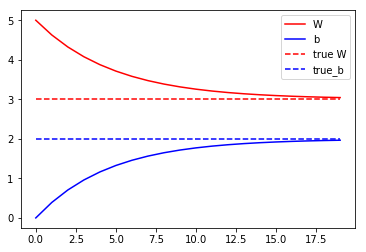

In [14]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(20)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)

    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()


### View the result

With our trained W and b, how well does the model do now?

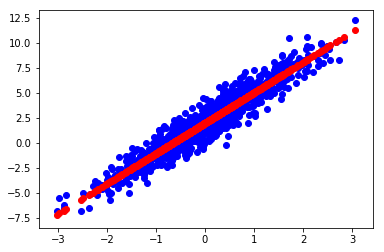

Current loss: 
0.96867234


In [15]:
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())